# Poetry Generation using Seq2Seq
In this notebook, I am exploring the poems data by Poetryfoundation.org and creating a RNN based model - Seq2Seq to generate the poems. The Seq2Seq model as the name suggests, consists of two RNN (LSTM or GRU) models. 

First is called an Encoder, which takes sentence as an input and outputs a summary of the sentence aka hidden state or vector.

a new sequence and is trained individually than Decoder unit. So, a single cell/unit in an encoder takes a single word as an input, processes it and outputs a vector (hidden state). This output vector is fed into a Dense layer with 'Softmax' as an activation function, which gives a probability against the words in the dictionary and the one with the highest probability is the next word in the sequence. 

While, the second is a Decoder, which generates an output sequence by taking two inputs; One the final hidden state from the Encoder and second a starting word or '<sos>' (start of sentence token). Each cell in the decoder also outputs a hidden state which is again then fed to a dense layer with 'Softmax' as an activation function, giving the probabilities against the words in the dictionary. The word with the highest probability is selected/outputed. The hidden state from this cell and the output word is fed to the next cell and the process is repeated until a '<eos>' (end of sentence token is generated).

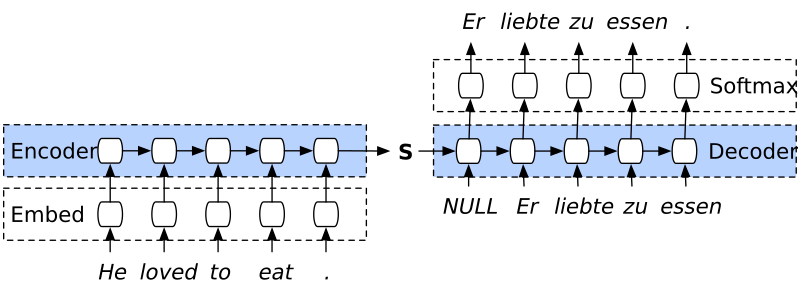

But, for Poem generation, since we don't have an input when we generate new ones, so, we will tweak the apporach a little bit. We will enhance the Encoder, that is we will train it seperately with its hidden vectors feeding into a dense layer with 'Softmax' as decribed above. Once we've trained the encoder, we will use the trained layers which will act as decoder for us. This approach is elaborated below.

**This Seq2Seq model is better than an ordinary RNN model because of the two primary reasons:**
* The output generated can be of variable length, i.e. not need to be of fixed size
* When we pass the hidden state of the Encoder to the Decoder we pass a summary of the entire sentence (context) to the decoder unit, which is really helpful while generating a new text.

**The brief of the process is mentioned below.**
1. **Reading the data:** The dataset contains a lot of poems from different poets. It's upto you to either use all the peoms to train the model or to use peoms by a specific poet. In this notebook I'll be using the ones by William Shakespeare
2. **Tokenize the data and generate sequences:** In this step we will be splitting the poems into tokens(words) and since lines in the poems can be of varying length we will also pad the sequences to make them of same length
3. **Prepare Word-embeddings:** Since, we cannot directly use the tokens/words in the neural networks we need a way to represent these into some numerical form. One of the intuitive method is to create the one-hot encodings but over the researchers have created a much much better method which has been named as embeddings. There are different methods to create the same and hence various pre-trained word-embeddings are available for our use. In this notebook, I've used GloVe by Stanford. I've already added these embeddings into the workspace and you can do the same in any of your projects by using the '+ Add Data' option present on the top right corner.
4. **Create the Seq2Seq model:** As described above we will create two LSTM/GRU models - an encoder and a decoder.
5. **Train the model:** The entire Seq2Seq model is trained
6. **Generate a Poem:** Finally, in this step we will generate our own poem :) Here, I've used a hack - adapting from the principles of a Memory Network to try to generate lines which have some relation amonst them. The detailed approach is mentioned below.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import spatial
from collections import Counter
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
ds_path = "complete-poetryfoundationorg-dataset/"
glove_path = "glove-global-vectors-for-word-representation/glove.6B.%dd.txt"

In [2]:
import keras.backend as K
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, Input, LSTM, GRU

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# 1. Reading the data

In [3]:
# read the poems dataset
poems_df = pd.read_csv(os.path.join(ds_path, "kaggle_poem_dataset.csv"))
poems_df.head(2)

,Unnamed: 0,Author,Title,Poetry Foundation ID,Content
0,0,Wendy Videlock,!,55489,"Dear Writers, I’m compiling the first in what ..."
1,1,Hailey Leithauser,0,41729,"Philosophic\nin its complex, ovoid emptiness,\..."


In [4]:
# groupby the Author and print the count of number of poems written by each of them
poems_df.groupby("Author").agg({"Content": "count"}).sort_values("Content", ascending=False).head(5)

,Content
Author,
William Shakespeare,85
Anonymous,82
"Alfred, Lord Tennyson",78
Rae Armantrout,62
William Wordsworth,59


In [5]:
# since Shakespeare has the most poems I am using that for training our model
william_poems = poems_df[poems_df["Author"] == "William Shakespeare"]
print("Some of the lines are: ")
print(william_poems.iloc[0, 4].split('\n')[:4])

Some of the lines are: 
['Let the bird of loudest lay', 'On the sole Arabian tree', 'Herald sad and trumpet be,', 'To whose sound chaste wings obey.']


In [6]:
# combine all the poems by seperating them with \n
poems_combined = "\n".join(william_poems.iloc[:, 4].values)
print("Total number of characters: ", len(poems_combined))

Total number of characters:  114070


In [7]:
# now we will be splitting the entire document into lines
poem_lines = poems_combined.split('\n')
print("Number of lines in the dataset: ", len(poem_lines))

Number of lines in the dataset:  3159


In [8]:
# prepare the input and target lines
input_lines = ["<sos> "+line for line in poem_lines] # in each of the input we add <sos> token idicating the begining of a line
target_lines = [line+ " <eos>" for line in poem_lines] # while target lines are appended with with <eos> token indicating end of the line

# 2. Tokenize the data and generate the sequences
# 3. Prepare Word-Embeddings

These two steps are mentioned together since, I've created a class to process the input/output sentences, prepare word-embeddings and generate the output senquences. Putting the repeatable code into a class helps to maintain the code and saves time in re-writing the repeatable codelines. Even you can pick this class and use in your own projects.

In [9]:
# there could be lines having a lot of words in them. But since we have to define the length of the sequene before hand 
# and we already know that LSTM/GRU are slow due to their sequential nature, we will try to keep the sequence length as small as possible 

# so, in the below snippet, we are calculating the frequencies of different sequence lengths
tokenized_lines = map(str.split, input_lines)
len_of_lines = map(len, tokenized_lines)
len_frequencies = Counter(list(len_of_lines))

# output the frequencies
sorted(len_frequencies.items())

[(1, 446),
 (2, 55),
 (3, 15),
 (4, 14),
 (5, 49),
 (6, 125),
 (7, 284),
 (8, 525),
 (9, 736),
 (10, 637),
 (11, 263),
 (12, 8),
 (41, 1),
 (149, 1)]

As we can see, we only have 2 such lines where the sequence lengths 41 or 149, so, we will cap the sequence length to 12

In [10]:
EPOCHS = 500 #500 number of times the model is trained on the entire training dataset
BATCH_SIZE = 64 # number of data points to consider to train at a single point of time
LATENT_DIM = 200 # the size of the hidden state/vector
EMBEDDING_DIM = 200 # size of the word embeddings - comes into various sizes 50, 100 or 200
MAX_VOCAB_SIZE = 30000 # the maximum number of words to consider
VALIDATION_SPLIT = 0.2 # % of validation dataset

In [11]:
# the process to get the word embeddings and tokenize the sentences is a repeatable part
# hence, I've created a class for easy management across the projects

class SequenceGenerator():
    
    # takes as input an input and output sequence
    def __init__(self, input_lines, target_lines, max_seq_len=None, max_vocab_size=10000, embedding_dim=200):
        """
            This is a class constructor.
            
            Parameters:
                input_lines (list): list of input sentences
                target_lines (list): list of target sentences
                max_seq_len (int): the maximum length of a single sequence
                max_vocab_size (int): the maximum number of words in the entire input & output datasets
                embedding_dim (int): length of a vector of a single word embedding
        """
        
        self.input_lines = input_lines
        self.target_lines = target_lines
        
        self.MAX_SEQ_LEN = max_seq_len
        self.MAX_VOCAB_SIZE = max_vocab_size
        self.EMBEDDING_DIM = embedding_dim
    
    
    def initialize_embeddings(self):
        """Reads the GloVe word-embeddings and creates embedding matrix and word to index and index to word mapping."""
        
        # load the word embeddings
        self.word2vec = {}
        with open(glove_path%self.EMBEDDING_DIM, 'r', encoding='utf-8') as file:
            for line in file:
                vectors = line.split()
                self.word2vec[vectors[0]] = np.asarray(vectors[1:], dtype="float32")

                
        # get the embeddings matrix
        self.num_words = min(self.MAX_VOCAB_SIZE, len(self.word2idx)+1)
        self.embeddings_matrix = np.zeros((self.num_words, self.EMBEDDING_DIM))
        
        for word, idx in self.word2idx.items():
            if idx <= self.num_words:
                word_embeddings = self.word2vec.get(word)
                if word_embeddings is not None:
                    self.embeddings_matrix[idx] = word_embeddings
                    
        self.idx2word = {v:k for k,v in self.word2idx.items()}
    
    
    def prepare_sequences(self, filters=''):
        """
            Initialize a tokenizer and train it on the input and target sentences.
            Also, it prepares the sequences by tokenizing and padding the sequences.
            
            Parameters:
                filters (str): mentioned characters in the list are removed from the sentences
        """
        
        # train the tokenizer
        self.tokenizer = Tokenizer(num_words=self.MAX_VOCAB_SIZE, filters='')
        self.tokenizer.fit_on_texts(self.input_lines+self.target_lines)
        
        # get the word-index mapping and initialize embeddings
        self.word2idx = self.tokenizer.word_index
        self.initialize_embeddings()
        
        # tokenize the input and target lines
        self.input_sequences = self.tokenizer.texts_to_sequences(self.input_lines)
        self.target_sequences = self.tokenizer.texts_to_sequences(self.target_lines)
        
        # get the max sequence len from the data
        max_seq_len = max(list(map(len, self.input_lines+self.target_lines)))
        if self.MAX_SEQ_LEN:
            self.MAX_SEQ_LEN = min(self.MAX_SEQ_LEN, max_seq_len)
        else:
            self.MAX_SEQ_LEN = max_seq_len
            
        # pad the sequences
        self.input_sequences = pad_sequences(self.input_sequences, maxlen=self.MAX_SEQ_LEN, padding="post")
        self.target_sequences = pad_sequences(self.target_sequences, maxlen=self.MAX_SEQ_LEN, padding="post")
        
        print("1st input sequence: ", self.input_sequences[0])
        print("1st target sequence: ", self.target_sequences[0])
        
        
    def one_hot_encoding(self):
        """Creates the One-hot encoding for the target sequence."""
        
        # it will be a 3 dimensional array where
        # first-dim is the number of target lines
        # second-dim is the size of the sequences
        # third-dim is the number of words in the dataset
        self.one_hot_targets = np.zeros((len(self.target_sequences), self.MAX_SEQ_LEN, self.num_words))
        
        for seq_idx, seq in enumerate(self.target_sequences):
            for word_idx, word_id in enumerate(self.target_sequences[seq_idx]):
                if word_id > 0:
                    self.one_hot_targets[seq_idx, word_idx, word_id] = 1
    
    
    def get_closest_word(self, word_vec):
        """
            Find the nearest word to the provided vector. The distance between the vectors is 
            calculated using the cosine-distance.
            
            Parameters:
                word_vec (np.array): a vector of size EMBEDDING_DIM
                
            Returns:
                Str: the closest word to the provided vector
        """
        
        max_dist = 9999999999
        closest_word = "NULL"
        
        # iterate overall the words and find the closest one
        for word, vec in self.word2vec.items():
            
            # get the cosine distance between the words
            dist = spatial.distance.cosine(word_vec, vec)
            
            # compare the distance and keep the minimum
            if dist < max_dist:
                max_dist = dist
                closest_word = word
        
        return closest_word


# create an object of the class
sg_obj = SequenceGenerator(input_lines, target_lines, max_seq_len=12, 
                           max_vocab_size=MAX_VOCAB_SIZE, embedding_dim=EMBEDDING_DIM)

# prepare the input & target sequences
sg_obj.prepare_sequences()
# create the One-hot encoding on the target sequences
sg_obj.one_hot_encoding()

# make sure the tokenized words contains <sos> & <eos>
assert '<sos>' in sg_obj.word2idx
assert '<eos>' in sg_obj.word2idx

1st input sequence:  [   1   75    3  514    6 1819  287    0    0    0    0    0]
1st target sequence:  [  75    3  514    6 1819  287    2    0    0    0    0    0]


# 4. Create Seq2Seq model

## Create the Encoder

In [12]:
# add the embedding layer
# input_dim: is the size of the embedding matrix
# output_dim: is the size of the embedding vector of a word
# weights: is the embedding_matrix we created in the SequenceGenerator class
embedding = Embedding(
    input_dim=sg_obj.num_words,
    output_dim=sg_obj.EMBEDDING_DIM,
    weights=[sg_obj.embeddings_matrix]
)

# since we are using the LSTM architecture, it has two internal states
# first is the hidden state (state_h), which is also the output of a LSTM cell
# second is the cell state (state_c)
# here we are initializing it as empty for the encoder
state_h = Input(shape=(LATENT_DIM,))
state_c = Input(shape=(LATENT_DIM,))

# this layer takes as input a single sequence
sequence_input = Input(shape=(sg_obj.MAX_SEQ_LEN,))

# the below layer gets the embeddings for the words in the sequence
embedding_ = embedding(sequence_input)

# once we have the embeddings these are passed to the LSTM units
# return_state: ensures that both the states are returned 
# return_sequences: ensures that the output (hidden state) of each of the cell is returned, 
# if return_sequences=false, only the hidden state of the last cell of LSTM is returned
lstm = LSTM(LATENT_DIM, return_state=True, return_sequences=True)

# also, we pass the embeddings as an input to the LSTM and also the initial states like below
x, h_, c_ = lstm(embedding_, initial_state=[state_h, state_c])

# as we discussed above, the output of the LSTM cells are fed to a dense layer
# the size of the dense layer is - number of words in the vocabulary
# 'softmax' activation is used, as this gives the probabilities for each of the word in the vocabulary
dense = Dense(sg_obj.num_words, activation="softmax")
output = dense(x)

# the Model brings all the inputs and the outputs under a single umbrella
# this makes the entire encoder model
Encoder = Model([sequence_input, state_h, state_c], output)

## Create the Decoder

In [13]:
# decoder takes as input a single word (index of the word)
deco_inp = Input(shape=(1,))

# the input word is converted to its embeddings
# we will use the same embedding layer as above
deco_embed = embedding(deco_inp)

# here also we will use the same LSTM (lstm) layer, since it is already trained
# only the new inputs will be passed to this
deco_x, h, c = lstm(deco_embed, initial_state=[state_h, state_c])
deco_output = dense(deco_x)

# combining all the layers to create Decoder model
Decoder = Model([deco_inp, state_h, state_c], [deco_output, h, c])

# 5. Train the model

In [14]:
# since this is a classification problem, we will use 'categorical_crossentropy' as the loss function
# optimizer used is the Adam optimizer with the learning rate of 0.01
Encoder.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.01),
    metrics=['accuracy']
)

# initial hidden/cell state vector containing all zeros
# this will be passed into the LSTM model
initial_state = np.zeros((len(sg_obj.input_sequences), LATENT_DIM))

# train the model
history = Encoder.fit(
    [sg_obj.input_sequences, initial_state, initial_state], # pass the input sequences and the state vectors
    sg_obj.one_hot_targets, # the one-hot encoding of the target sequences
    batch_size=BATCH_SIZE, # the batch size
    epochs=EPOCHS, # number of times to train the model
    validation_split=VALIDATION_SPLIT, # % of data for validation
    verbose=1 # to suppress the information printed for each epoch
)

D:\Users\Groh_Justin\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2527 samples, validate on 632 samples
Epoch 1/500
2527/2527 [==============================] - 7s 3ms/step - loss: 4.5116 - accuracy: 0.0840 - val_loss: 4.4135 - val_accuracy: 0.0831
Epoch 2/500
2527/2527 [==============================] - 4s 2ms/step - loss: 3.7804 - accuracy: 0.0921 - val_loss: 4.4632 - val_accuracy: 0.0986
Epoch 3/500
2527/2527 [==============================] - 4s 2ms/step - loss: 3.4506 - accuracy: 0.1060 - val_loss: 4.5225 - val_accuracy: 0.1051
Epoch 4/500
2527/2527 [==============================] - 4s 2ms/step - loss: 3.1423 - accuracy: 0.1231 - val_loss: 4.6346 - val_accuracy: 0.1022
Epoch 5/500
2527/2527 [==============================] - 4s 2ms/step - loss: 2.7922 - accuracy: 0.1475 - val_loss: 4.7514 - val_accuracy: 0.1034
Epoch 6/500
2527/2527 [==============================] - 4s 2ms/step - loss: 2.4104 - accuracy: 0.1901 - val_loss: 4.9061 - val_accuracy: 0.0998
Epoch 7/500
2527/2527 [==============================] - 4s 2ms/step - loss: 2.0490

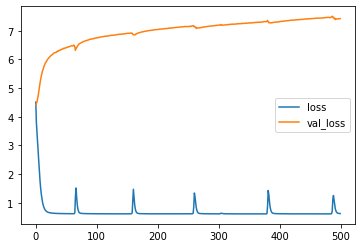

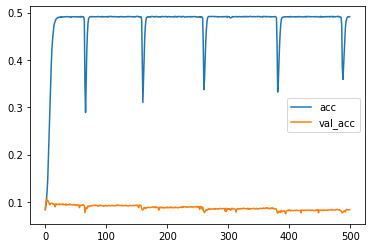

In [15]:
# though here the accuracies does not matter to us, since
# we are not going to try to produce the inputs as it is

# plot the losses for both training and testing
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# plot the accuracies for both training and testing
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# 6. Generate a Poem

We can pass a starting word to our decoder and start generating the words from it, until <eos> token is generated and the process is repeated to generate as many lines as we want.
    
But, the problem with this is, there may not be any relation between the words. So, here I am using a hack (taking from the principles of a Memory network) to try to provide some context before generating a new line.

In [16]:
def get_context(sequences, query_word):
    """
        This function takes as input multiple lines generated by the model so far and a query_word or the theme of the poem.
        
        So, the approach is we will add the embeddings of all the words in a sentence to get the sentence embeddings and will
        create the sentence embeddings for all the sentences created so far.
        
        Now, to summarize all the sentence embeddings into a single vector, we will calculate the distance of all the sentence
        from the query_word. These weights are normalized and will be used as the weights to combine the sentence embeddings.
        
        This final embedding vector or the context will be passed to the Decoder as a hidden state and a new line is generated from it.
    """
    
    assert query_word in sg_obj.word2idx
    
    # null vector containing all zeroes
    query_word_embed = sg_obj.word2vec.get(query_word, np.zeros(shape=(EMBEDDING_DIM)))
    
    if sequences == []:
        return query_word_embed
    
    # to keep all the sentence embeddings
    seq_embeddings = []
    for seq in sequences:
        
        # add up all the word embeddings of a sequence
        zero_vector = np.zeros(shape=(EMBEDDING_DIM))
        for word in seq:
            zero_vector += sg_obj.word2vec.get(word, np.zeros(shape=(EMBEDDING_DIM)))
            
        seq_embeddings.append(zero_vector)
    seq_embeddings = np.array(seq_embeddings)
            
    weights = []
    for seq_embed in seq_embeddings:
        # get the distance between the query word and the sentence embeddings
        dist = spatial.distance.cosine(seq_embed, query_word_embed)
        weights.append(np.array([dist]))
        
    # normalize the distances
    weights = np.array(weights/max(weights))
        
    # get the final weighted context
    context = sum(weights * seq_embeddings)
    
    return context

In [17]:
def get_sample_line(context):
    """
        Get a single line using the provided context as a hidden state
        
        Parameters:
            context (np.array): generated context of the same size as the word_embedding
    """
    
    # sentence start token
    sos_token = np.array([[sg_obj.word2idx.get("<sos>")]])
    
    # create the empty lstm state vectors
    h = np.array([context])    
    c = np.zeros(shape=(1, LATENT_DIM))
    
    # so we know when to quit
    eos_token = sg_obj.word2idx['<eos>']
    
    output_sequence = []
    
    # limit the length of the generated line
    for i in range(sg_obj.MAX_SEQ_LEN):
        
        # predict the first word
        # the outputed stated are passed to the lstm to generate the next word in the sequence
        o, h, c = Decoder.predict([sos_token, h, c])
        
        # get the probabilities generated from the dense layer
        probs = o[0,0]
        
        if np.argmax(probs) ==0:
            print("Something went wrong!!")
        
        probs = np.nan_to_num(probs)
        # the word-indices starts from 1 so 1st value does not count
        probs[0] = 0 
        
        # normalize the probabilities
        probs /= probs.sum()
        
        # select a random word with provided probability of being selected
        selected_idx = np.random.choice(len(probs), p=probs)
        
        # if the generated word is equal to eos_token, terminate
        if selected_idx == eos_token:
            break
        
        # append the generated word to the output_sequence
        output_sequence.append(sg_obj.idx2word.get(selected_idx, "Error <%d>" % selected_idx))
        
        # the word generated will be used as an input to generated the new word
        sos_token[0][0] = selected_idx
    
    # return the sequence
    return output_sequence

### Finally, we will use the above created get_context and get_sample_lines functions to generate the poem

In [18]:
# the theme of the poem - only single word (for simplicity)
query_word = "love"

# to append the generated poem lines
poem_lines = []

# first sequence containing only ones, this will be used to generate the context
sequences = []

# we will be generating 8 lines, you can play around with this
for line_no in range(8):
    
    # get the context, for the first line the context will contain the embeddings of the theme words itself
    context = get_context(sequences, query_word)
    
    try:
        # generate a new line and append it
        sequences.append(get_sample_line(context))
    except:
        pass
    
    poem_lines.append(" ".join(sequences[-1]))
    
print("\n\n")
print("\n".join(poem_lines))

Something went wrong!!
Something went wrong!!
Something went wrong!!
Something went wrong!!
Something went wrong!!
Something went wrong!!
Something went wrong!!













D:\Users\Groh_Justin\.conda\envs\nlp\lib\site-packages\scipy\spatial\distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
D:\Users\Groh_Justin\.conda\envs\nlp\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


In [19]:
import joblib

joblib.dump({
    "Encoder": Encoder,
    "Decoder": Decoder,
    "tokenizer": sg_obj.tokenizer,
    "word2idx": sg_obj.word2idx,
    "idx2word": sg_obj.idx2word,
    "word2vec": sg_obj.word2vec            # <<< FEHLT BEI DIR
}, "poem_generator.pkl")

['poem_generator.pkl']

In [20]:
data = joblib.load("poem_generator_2.pkl")
Encoder = data["Encoder"]
Decoder = data["Decoder"]
tokenizer = data["tokenizer"]

D:\Users\Groh_Justin\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
D:\Users\Groh_Justin\.conda\envs\nlp\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [21]:
def get_context_multiple_words(sequences, query_words):
    """
        Diese Funktion akzeptiert jetzt mehrere Wörter als Themen.
        Sie kombiniert deren Embeddings (durch Mittelwertbildung)
        und berechnet daraus den Kontextvektor.
    """

    # falls nur ein Wort übergeben wurde, in Liste umwandeln
    if isinstance(query_words, str):
        query_words = [query_words]

    # alle Wörter müssen im Vokabular sein
    valid_words = [w for w in query_words if w in sg_obj.word2vec]
    if not valid_words:
        raise ValueError("Keines der query_words ist im Vokabular enthalten.")

    # kombiniertes Embedding als Mittelwert aller Themenwörter
    query_embeds = [sg_obj.word2vec[w] for w in valid_words]
    query_word_embed = np.mean(query_embeds, axis=0)

    if not sequences:
        return query_word_embed

    # Satz-Embeddings aus den bisherigen Sequenzen berechnen
    seq_embeddings = []
    for seq in sequences:
        zero_vector = np.zeros(shape=(EMBEDDING_DIM))
        for word in seq:
            zero_vector += sg_obj.word2vec.get(word, np.zeros(shape=(EMBEDDING_DIM)))
        seq_embeddings.append(zero_vector)
    seq_embeddings = np.array(seq_embeddings)

    # Gewichtung basierend auf Kosinus-Distanz
    weights = []
    for seq_embed in seq_embeddings:
        dist = spatial.distance.cosine(seq_embed, query_word_embed)
        weights.append(np.array([dist]))

    weights = np.array(weights / max(weights))

    # gewichtetes Summieren
    context = sum(weights * seq_embeddings)

    return context

In [34]:
# mehrere Themenwörter
query_words = ["love", "heart", "dream"]

poem_lines = []
sequences = []

for line_no in range(8):
    context = get_context_multiple_words(sequences, query_words)
    try:
        sequences.append(get_sample_line(context))
    except:
        pass
    poem_lines.append(" ".join(sequences[-1]))

print("\n".join(poem_lines))

though mine be not so fair, yet are they red,--
and her eyes more red than her lips' red;
clouds and here
cypress
beauty's pattern of a little breast.
clouds and seen!
on his breast.
clouds and here
